# Imports

In [1]:
import pandas as pd
import numpy as np 

from sklearn.cluster import DBSCAN, KMeans
from sklearn.neighbors import NearestNeighbors

import seaborn as sns
import matplotlib.pyplot as plt

from scipy.spatial.distance import cdist

from kneed import KneeLocator

import pickle

%matplotlib inline

In [2]:
import sklearn
print(sklearn.__version__)

1.0.2


# Data

In [3]:
# Small Dataset
data = pd.read_csv('../data_json/crash_rate_final.csv', index_col='Unnamed: 0')
data = data[(data.latitude > 30) & (data.longitude < -115)]  # filter out clear outlier values
data.head()

,street,traffic volume,accident count,crash_rate,latitude,longitude,risk level,Frequent_Day,Frequent_Hour
0,"102ND ST, Los Angeles",2238,184,8.22,33.944103,-118.254688,low,Friday,14
1,"103RD ST, Los Angeles",138801,531,0.38,33.942642,-118.243168,low,Tuesday,14
2,"104TH ST, Los Angeles",17741,239,1.35,33.941790,-118.369982,low,Saturday,17
3,"105TH ST, Los Angeles",14131,178,1.26,34.750118,-118.316244,low,Tuesday,1
4,"10TH AV, Los Angeles",3642,145,3.98,34.037828,-118.327656,low,Saturday,15


<AxesSubplot:xlabel='longitude', ylabel='latitude'>

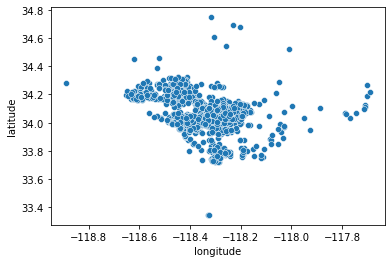

In [4]:
sns.scatterplot(data=data, x='longitude', y='latitude')

In [141]:
# Large dataset
data2 = pd.read_csv('../data_json/data_dbscan.csv.zip')
data2.head()

,DR Number,Area ID,Area Name,Premise Description,Address,Cross Street,month,day,year,hour,...,Date,Day,haversine_distance,closest street,traffic volume,accident count,crash rate,frequent day,frequent hour,label
0,100100007,1,Central,STREET,PICO,HOPE,11,8,2010,22,...,2010-11-8,Monday,0.592942,"10TH ST, Los Angeles",2750,127,4.62,Wednesday,2,0
1,100100767,1,Central,STREET,1300 N BROADWAY,NaN,3,31,2010,4,...,2010-3-31,Wednesday,0.383161,"SOLANO AV, Los Angeles",21620,2404,11.12,Friday,13,1
2,100100831,1,Central,STREET,PICO,CHERRY,4,18,2010,1,...,2010-4-18,Sunday,0.442127,"ALBANY ST, Los Angeles",8232,1369,16.63,Sunday,8,2
3,100101004,1,Central,STREET,FIGUEROA,WASHINGTON BL,6,5,2010,20,...,2010-6-5,Saturday,0.580183,"PARK GROVE AV, Los Angeles",39584,11,0.03,Tuesday,1,2
4,100101322,1,Central,STREET,COLLEGE,ALAMEDA,8,7,2010,16,...,2010-8-7,Saturday,0.007885,"COLLEGE ST, Los Angeles",18790,230,1.22,Friday,16,2


In [142]:
# data2[data2.haversine_distance > 1]['DR Number'].to_csv('../../drs_to_remove.csv')

# Clustering on Small Dataset

In [5]:
coords = data[['latitude', 'longitude']]

## Kmeans+

In [177]:
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 75)
 
for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(coords)
    kmeanModel.fit(coords)
 
    distortions.append(sum(np.min(cdist(coords, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / coords.shape[0])
    inertias.append(kmeanModel.inertia_)
 
    mapping1[k] = sum(np.min(cdist(coords, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / coords.shape[0]
    mapping2[k] = kmeanModel.inertia_

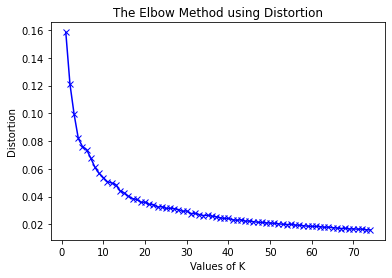

In [178]:
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

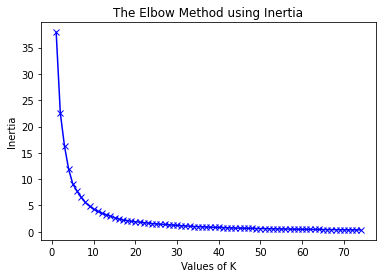

In [179]:
plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()

In [211]:
labeled_data = data.copy()
km = KMeans(10).fit(coords)
labeled_data['label'] = km.labels_

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

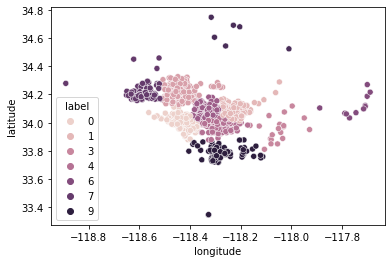

In [212]:
sns.scatterplot(data=labeled_data, x='longitude', y='latitude', hue='label')

In [200]:
pickle.dump(km, open("kmeans.pkl", "wb"))
labeled_data.to_csv('../../clusterings/4-20-22/kmeans_k=25.csv', index=False)

In [6]:
wccs = []
labeled_data = data.copy()

for i in range(5):
    km = KMeans(25).fit(coords)
    wcc = km.inertia_
    wccs.append(wcc)

    if wcc == min(wccs):
        pickle.dump(km, open("kmeans.pkl", "wb"))
        labeled_data['label'] = km.labels_
        labeled_data.to_csv('../../clusterings/4-20-22/kmeans_k=25.csv', index=False)


In [7]:
tmp = pd.read_csv('../../clusterings/4-20-22/kmeans_k=25.csv')

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

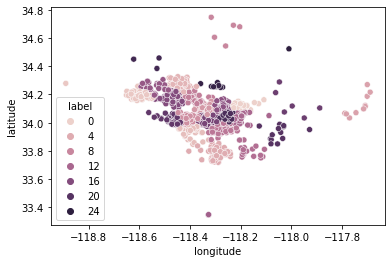

In [8]:
sns.scatterplot(data=tmp, x='longitude', y='latitude', hue='label')


In [9]:
tmp.label.value_counts()

21    90
15    88
17    77
4     69
6     68
0     63
12    61
19    60
10    58
16    57
3     51
2     46
1     46
7     46
9     41
14    34
11    20
20    13
5     10
23     9
18     6
8      5
22     3
13     2
24     1
Name: label, dtype: int64

In [203]:
pd.read_csv('../../clusterings/4-20-22/kmeans_k=25.csv')

,street,traffic volume,accident count,crash_rate,latitude,longitude,risk level,Frequent_Day,Frequent_Hour,label
0,"102ND ST, Los Angeles",2238,184,8.22,33.944103,-118.254688,low,Friday,14,18
1,"103RD ST, Los Angeles",138801,531,0.38,33.942642,-118.243168,low,Tuesday,14,18
2,"104TH ST, Los Angeles",17741,239,1.35,33.941790,-118.369982,low,Saturday,17,5
3,"105TH ST, Los Angeles",14131,178,1.26,34.750118,-118.316244,low,Tuesday,1,13
4,"10TH AV, Los Angeles",3642,145,3.98,34.037828,-118.327656,low,Saturday,15,8
...,...,...,...,...,...,...,...,...,...,...
1019,"YOLANDA AV, Los Angeles",24334,76,0.31,34.195669,-118.540414,low,Monday,7,16
1020,"YORK BL, Los Angeles",271200,158,0.06,33.957271,-118.050991,low,Monday,18,14
1021,"YUCCA ST, Los Angeles",22468,204,0.91,34.103720,-118.324950,low,Monday,6,20
1022,"ZELZAH AV, Los Angeles",96051,110,0.11,34.243016,-118.523271,low,Monday,8,1


In [202]:
labeled_data.label.value_counts()

12    89
19    88
11    73
22    69
0     65
6     64
21    60
15    60
20    58
8     57
18    54
5     49
17    49
16    49
4     43
1     26
2     21
14    16
7     13
3      8
13     5
23     3
9      2
10     2
24     1
Name: label, dtype: int64

## DBSCAN

In [132]:
min_samples = 4
coords = data[['latitude', 'longitude']]

### Euclidean

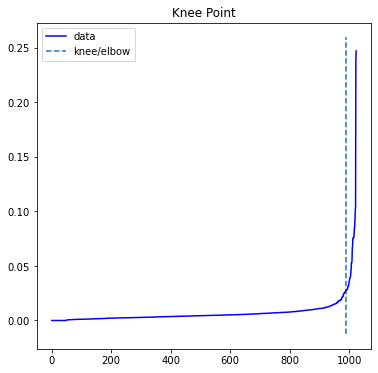

In [98]:
min_samples = 4

coords = data[['latitude', 'longitude']]

neighbors = NearestNeighbors(n_neighbors=min_samples, algorithm='ball_tree', metric='euclidean')
neighbors_fit = neighbors.fit(coords)
distances, indices = neighbors_fit.kneighbors(coords)

distances = np.sort(distances, axis=0)
distances = distances[:, 1]
i = np.arange(len(distances))
knee = KneeLocator(i, distances, S=1, curve='convex', direction='increasing')
knee.plot_knee()
eps = distances[knee.knee]

In [99]:
labeled_data = data.copy()

db = DBSCAN(eps=eps, min_samples=4, metric='euclidean', algorithm='ball_tree').fit(coords)
labels = db.labels_
labeled_data['label'] = labels

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

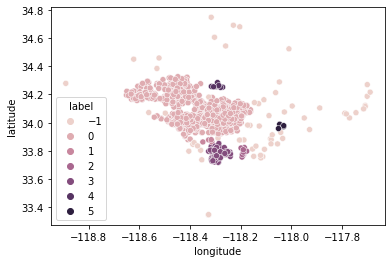

In [100]:
sns.scatterplot(data=labeled_data, x='longitude', y='latitude', hue='label')

In [101]:
labeled_data.label.value_counts()

 0    870
-1     64
 3     64
 2     10
 4      8
 1      4
 5      4
Name: label, dtype: int64

### Haversine

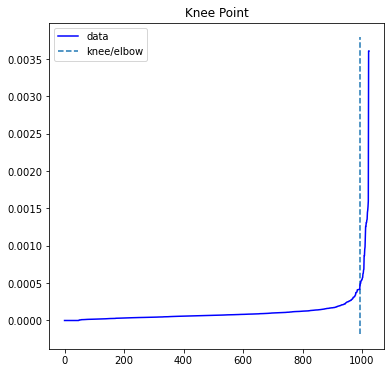

In [133]:
min_samples = 4

neighbors = NearestNeighbors(n_neighbors=min_samples, algorithm='ball_tree', metric='haversine')
neighbors_fit = neighbors.fit(np.radians(coords))
distances, indices = neighbors_fit.kneighbors(np.radians(coords))

distances = np.sort(distances, axis=0)
distances = distances[:, 1]
i = np.arange(len(distances))
knee = KneeLocator(i, distances, S=1, curve='convex', direction='increasing')
knee.plot_knee()
eps = distances[knee.knee]

In [134]:
eps * 6371.0088

2.6507654829108964

In [135]:
labeled_data = data.copy()

db = DBSCAN(eps=eps, min_samples=4, metric='haversine', algorithm='ball_tree').fit(np.radians(coords))
labels = db.labels_
labeled_data['label'] = labels

In [137]:
labeled_data.to_csv('../../clusterings/4-20-22/dbscan-clusters-4-24-22.csv')

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

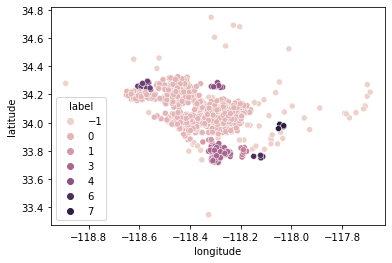

In [136]:
sns.scatterplot(data=labeled_data, x='longitude', y='latitude', hue='label')

In [109]:
labeled_data['label'].value_counts()

 0    857
 3     64
-1     60
 5     13
 2     10
 4      8
 1      4
 6      4
 7      4
Name: label, dtype: int64

# Clustering with bigger dataset

## Kmeans+

## DBSCAN

In [123]:
coords = data2[['Latitude', 'Longitude']]

min_samples = 6


### Euclidean

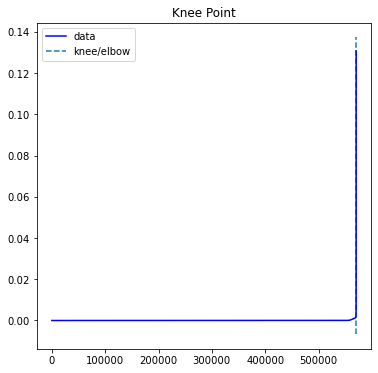

In [118]:
neighbors = NearestNeighbors(n_neighbors=min_samples, algorithm='ball_tree', metric='euclidean')
neighbors_fit = neighbors.fit(coords)
distances, indices = neighbors_fit.kneighbors(coords)

distances = np.sort(distances, axis=0)
distances = distances[:, 1]
i = np.arange(len(distances))
knee = KneeLocator(i, distances, S=1, curve='convex', direction='increasing')
knee.plot_knee()
eps = distances[knee.knee]

In [119]:
eps

0.004301162633521862

In [120]:
labeled_data = data2.copy()

db = DBSCAN(eps=eps, min_samples=4, metric='euclidean', algorithm='ball_tree').fit(coords)
labels = db.labels_
labeled_data['label'] = labels

<AxesSubplot:xlabel='Longitude', ylabel='Latitude'>

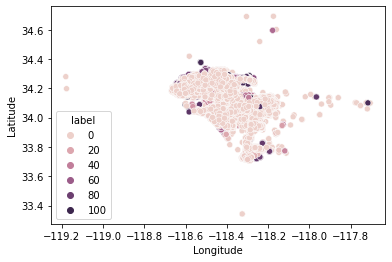

In [121]:
sns.scatterplot(data=labeled_data, x='Longitude', y='Latitude', hue='label')

In [122]:
labeled_data['label'].value_counts()

0     557339
3       8332
52       459
70       293
40       225
       ...  
85         4
77         4
82         4
95         4
25         3
Name: label, Length: 109, dtype: int64

### Haversine

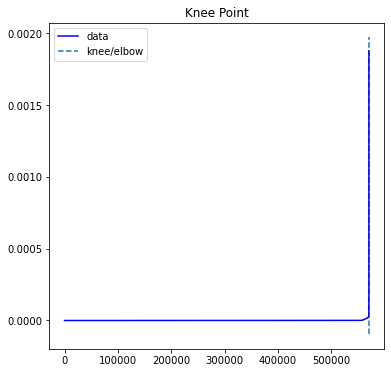

In [111]:
min_samples = 4

neighbors = NearestNeighbors(n_neighbors=min_samples, algorithm='ball_tree', metric='haversine')
neighbors_fit = neighbors.fit(np.radians(coords))
distances, indices = neighbors_fit.kneighbors(np.radians(coords))

distances = np.sort(distances, axis=0)
distances = distances[:, 1]
i = np.arange(len(distances))
knee = KneeLocator(i, distances, S=1, curve='convex', direction='increasing')
knee.plot_knee()
eps = distances[knee.knee]

In [112]:
eps * 6371.0088

0.24532754242940022

In [114]:
labeled_data = data2.copy()

db = DBSCAN(eps=eps, min_samples=4, metric='haversine', algorithm='ball_tree').fit(np.radians(coords))
labels = db.labels_
labeled_data['label'] = labels

<AxesSubplot:xlabel='Longitude', ylabel='Latitude'>

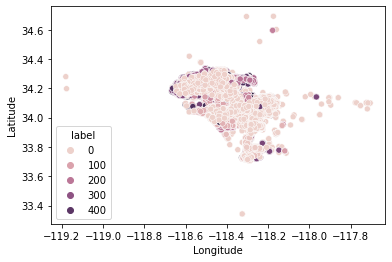

In [116]:
sns.scatterplot(data=labeled_data, x='Longitude', y='Latitude', hue='label')

In [117]:
labeled_data['label'].value_counts()

0      347763
6      170884
13       9243
68       8885
4        8083
        ...  
174         4
414         4
343         4
441         4
483         3
Name: label, Length: 488, dtype: int64

In [ ]:
for label in 

min_samples = 10
neighbors = NearestNeighbors(n_neighbors=4, algorithm='ball_tree', metric='haversine')
neighbors_fit = neighbors.fit(np.radians(coords))
distances, indices = neighbors_fit.kneighbors(np.radians(coords))